#### L1 正則化の利点は？

L1 normalization を用いたmodelを学習させると、paramter の最適解として、疎 sparseな解が得られます。
sparseとは、具体的に

```
w=(0,5,0,0,2,0,...,0)
```

のように、成分のほとんどが0であるベクトルや行列の状態を表します。

L1 normalization をして0となる成分が、irrelevant feature にあたります。

L1 normalization の使い時は、無関係な次元の数　＞　サンプル数となる場合です。使って、特徴量を減らしましょう。

In [2]:
# wineのデータの読み込み
import pandas as pd
from sklearn.model_selection import train_test_split

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Feature scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

#### L1正則化したロジスティック回帰を学習させます。

In [3]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)

print('train acc', lr.score(X_train_std, y_train))
print('test acc', lr.score(X_test_std, y_test))

train acc 0.983870967742
test acc 0.981481481481


train, testの精度ともに高く、離れていないことから、L1正則化により、over-fittingが回避できていることがわかります。

In [4]:
# sparseな解の確認
pd.DataFrame(lr.coef_) # 見やすさのためDataFrameに変換
# jupyter notebook で実行してください。

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.279961,0.000000,0.000000,-0.027974,0.0,0.0,0.709905,0.0,0.0,0.000000,0.000000,0.00000,1.236894
1,-0.644029,-0.068817,-0.057187,0.000000,0.0,0.0,0.000000,0.0,0.0,-0.926648,0.060215,0.00000,-0.371045
2,0.000000,0.061469,0.000000,0.000000,0.0,0.0,-0.637013,0.0,0.0,0.498548,-0.358139,-0.57013,0.000000


In [6]:
pd.DataFrame(lr.coef_).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,3.000000,3.000000,3.000000,3.000000,3.0,3.0,3.000000,3.0,3.0,3.000000,3.000000,3.000000,3.000000
mean,-0.121356,-0.002449,-0.019062,-0.009325,0.0,0.0,0.024297,0.0,0.0,-0.142700,-0.099308,-0.190043,0.288616
std,0.473798,0.065178,0.033017,0.016151,0.0,0.0,0.673788,0.0,0.0,0.723234,0.226167,0.329165,0.841927
min,-0.644029,-0.068817,-0.057187,-0.027974,0.0,0.0,-0.637013,0.0,0.0,-0.926648,-0.358139,-0.570130,-0.371045
25%,-0.322015,-0.034409,-0.028594,-0.013987,0.0,0.0,-0.318507,0.0,0.0,-0.463324,-0.179070,-0.285065,-0.185523
50%,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
75%,0.139980,0.030735,0.000000,0.000000,0.0,0.0,0.354953,0.0,0.0,0.249274,0.030108,0.000000,0.618447
max,0.279961,0.061469,0.000000,0.000000,0.0,0.0,0.709905,0.0,0.0,0.498548,0.060215,0.000000,1.236894


#### regularization parameter C を変えると sparsity がどう変わるのか、見てみましょう。
sparsityとは、sparse性のことです。

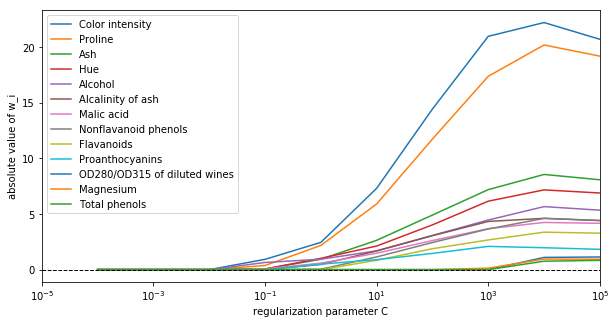

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


weights, params = [], []

for c in np.arange(-4.0, 6.0):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

w_abs = np.abs(weights)

plt.figure(figsize=(10,5))

feat_labels = df_wine.columns[1:]
# 平均を大きい順にしたときのindex
indices = np.argsort(np.mean(w_abs, axis=0))[::-1]

for i in indices:
    plt.plot(params, w_abs[:, i], label=feat_labels[i])

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlim([10**(-5), 10**5])
plt.ylabel('absolute value of w_i')
plt.xlabel('regularization parameter C')
plt.xscale('log')
plt.legend()
plt.show()

- Cが小さくなる = 正則化効果が大きくなる ほど、sparsity は強くなる
- 各成分の絶対値（Fig3の縦軸）に対し、任意の閾値を設けることにより、feature selection を行います。
絶対値が大きいほど、重要な特徴量なのでした。

### Randome Forest

In [3]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=1)
# tree, forestは、standardization 不要
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [4]:
forest.feature_importances_

array([ 0.10658906,  0.02539968,  0.01391619,  0.03203319,  0.02207807,
        0.0607176 ,  0.15094795,  0.01464516,  0.02235112,  0.18248262,
        0.07824279,  0.1319868 ,  0.15860977])

In [5]:
mportances = forest.feature_importances_
# 大きい順にしたときのindexたち
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

### Feature Seleciton まとめ
- feature selection
 - 特徴量を選択することにより、次元を減らす
 - 目的
  - over-fitting回避
  - 計算量削減
- 不要な特徴量
 - irrelevant feature
 - redundant feature
- filter
 - 評価指標: 1つの特徴量　に対し計算できる、簡単な数値
  - e.g. 分散
 - 計算コスト: 少
 - 効果: 小
 - 削れる特徴量: irrelevantはよく削れる
 - 学んだ手法・ライブラリ
  - VarianceThreshold
  - SelectKBest
 - その他
  - wrapperの前処理として使う
- wrapper
 - 評価指標: 特徴量の組み合わせ　に対する、モデルのvalidation performance
  - e.g LogisticRegression, SVMのaccuracy
 - 計算コスト: 大
 - 効果: 大
 - 削れる特徴量: redundantも
 - 学んだ手法・ライブラリ
  - RFE(全探索)
  - SBS(greedy backward search)
 - その他
  - 効率のいい探索アルゴリズム
  - データが少ないとover-fittingしやすい
- embedded
  - 評価指標: model内の評価指標
   - L1: 解の各成分の絶対値
   - random forest: information gain
  - 計算コスト: 中
  - 効果: 中
  - 学んだ手法・ライブラリ
   - L1 normalization
   - RandomForest